In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
TRAIN_VAL_SPLIT = 1000
WINDOW_SIZE = 20
BATCH_SIZE = 128
SHUFFER_BUFFER_SIZE = 1000

In [3]:
from util import load_synthesized_data, build_dataset

df_train, df_val = load_synthesized_data(split=1000)
y_train = df_train['y'].values

dataset = build_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, SHUFFER_BUFFER_SIZE)

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import SGD

def build_model():
    model = Sequential([
        Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
        SimpleRNN(40, return_sequences=True),
        SimpleRNN(40),
        Dense(1),
        Lambda(lambda x: x * 100.0)
    ])
    return model

In [5]:
from tensorflow.keras.callbacks import LearningRateScheduler
from util import clear_env

clear_env()

model = build_model()
model.compile(loss=Huber(), optimizer=SGD(lr=1e-8, momentum=0.9), metrics=['mae'])

def learning_rate(epoch):
    return 1e-8 * 10**(epoch / 20)

lr_schedule = LearningRateScheduler(learning_rate)

history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

W0807 21:43:14.954159  2444 deprecation.py:323] From d:\Dev\Miniconda3\envs\tf2\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


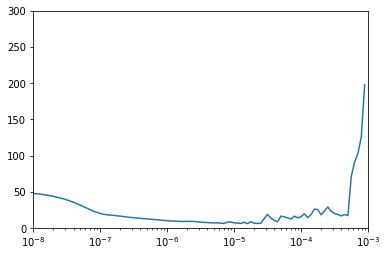

In [6]:
plt.figure()
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-3, 0, 300])
plt.show()

Select learning rate = 1e-5.

In [7]:
import matplotlib.pyplot as plt
from util import validate

def plot_history(history, start_epoch=1):
    loss = history.history['loss'][(start_epoch - 1):]
    epoch = range(start_epoch, len(history.history['loss']) + 1)
    plt.plot(epoch, loss)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

def validate_model(model):
    df_forecast = df_data.copy()
    df_forecast['y_hat'] = 0
    for t in range(WINDOW_SIZE, len(df_data)):
        y_val = df_data['y'][(t - WINDOW_SIZE):t, ].values
        forecast_value = model.predict(y_val[np.newaxis])
        df_forecast.loc[t, 'y_hat'] = forecast_value[0, 0]

    validate(df_forecast[TRAIN_VAL_SPLIT:])

In [8]:
clear_env()

model = build_model()
model.compile(loss=Huber(), optimizer=SGD(lr=1e-5, momentum=0.9), metrics=['mae'])

history = model.fit(dataset, epochs=100, verbose=0)

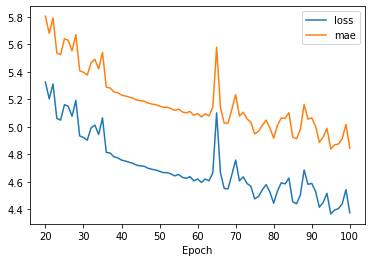

In [9]:
from util import plot_history, validate_model

plot_history(history, start_epoch=20, metrics=['loss', 'mae'])

MSE: 64.95743925591864, MAE: 5.918819788634894


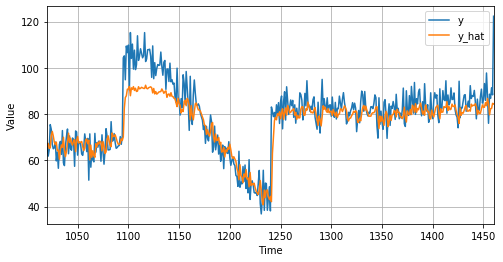

In [10]:
validate_model(model, df_val, WINDOW_SIZE)